In [119]:
# Code to get the image coordinated in the image place for sample images
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline


def get_cam_cal(imagePath):
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(imagePath)
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        
        img = cv2.imread(fname)
        # img_size = (img.shape[1], img.shape[0])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow('img', img)
            cv2.waitKey(500)
        
            cv2.destroyAllWindows()
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (1280, 720), None, None)
        
    return mtx, dist

In [2]:
def cal_undistort(img, mtx, dist):
    # Use cv2.calibrateCamera() and cv2.undistort()
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


In [3]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
   
    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return binary_output 

In [4]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    return binary_output

In [5]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

In [6]:
def hls_select(img, thresh=(0, 255)):
   
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output
    

In [7]:
mtx, dist = get_cam_cal("../CarND-Advanced-Lane-Lines/camera_cal/calibration*.jpg")

In [105]:
test_image = cv2.imread("../CarND-Advanced-Lane-Lines/test_images/test3.jpg")

# undistort the image 
test_image = cal_undistort(test_image, mtx, dist)

gradx = abs_sobel_thresh(test_image, orient='x', thresh_min=20, thresh_max=255)
grady = abs_sobel_thresh(test_image, orient='y', thresh_min=20, thresh_max=255)
mag_binary = mag_thresh(test_image, sobel_kernel=9, mag_thresh=(20, 255))
dir_binary = dir_threshold(test_image, sobel_kernel=15, thresh=(.5,1.3))

combined_grad = np.zeros_like(dir_binary)
combined_grad[((gradx == 1) & (grady == 1)) & ((mag_binary == 1) & (dir_binary == 1))] = 1

s_channel_binary = hls_select(test_image, thresh=(100,255))

combined_grad_color = np.zeros_like(combined_grad)
combined_grad_color[(combined_grad == 1) | (s_channel_binary == 1)] = 1

In [9]:
cv2.imshow('test_image', test_image)
#cv2.waitKey(10000)
cv2.destroyAllWindows()


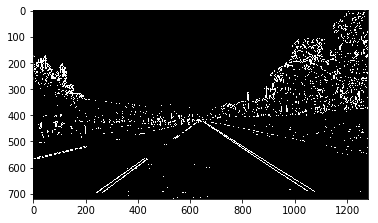

In [10]:
plt.imshow(gradx, cmap='gray')

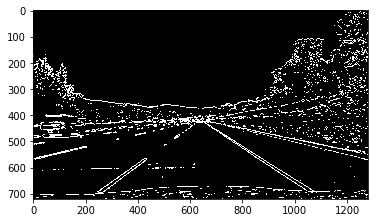

In [11]:
plt.imshow(grady, cmap='gray')

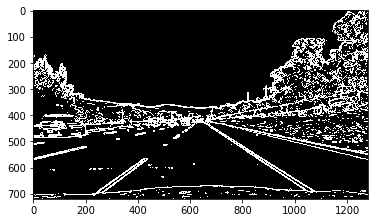

In [12]:
plt.imshow(mag_binary, cmap='gray')

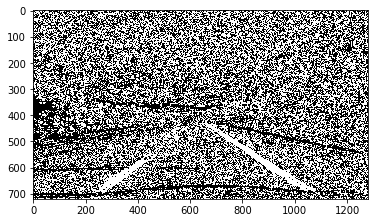

In [13]:
plt.imshow(dir_binary, cmap='gray')

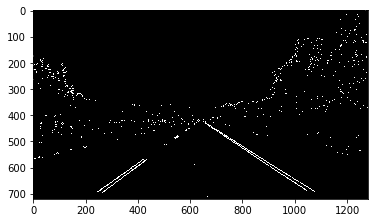

In [14]:
plt.imshow(combined_grad, cmap='gray')

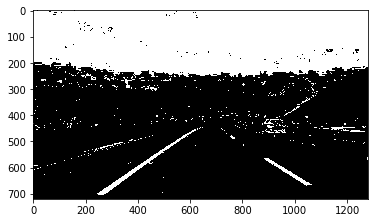

In [106]:
plt.imshow(combined_grad_color, cmap='gray')

In [131]:
def prespective(img, src, dst):        
        
        
        M = cv2.getPerspectiveTransform(src, dst)
        Minv = cv2.getPerspectiveTransform(dst, src)
        warped = cv2.warpPerspective(img, M, img.shape[::-1], flags=cv2.INTER_LINEAR)
        return warped, M, Minv


In [132]:
src = np.float32([[200, 720],
                  [600, 450],
                  [ 700, 450],
                  [1100, 720]])

dst = np.float32([[200, 720],
                  [200, 0],
                  [1100, 0],
                  [1100, 720]])

In [133]:
binary_warped, M, Minv = prespective(combined_grad_color, src, dst)

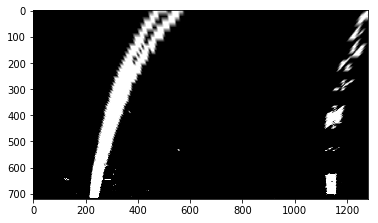

In [135]:
plt.imshow(binary_warped, cmap='gray')

In [136]:
# dectecting the lines in the above image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

In [138]:
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

In [143]:
nwindows = 9
window_height = np.int(binary_warped.shape[0]/nwindows)

In [146]:
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

In [149]:
margin = 100

In [150]:
minpix = 50

In [151]:
left_lane_inds = []
right_lane_inds = []